take sweeps with ZI and move across the beam

In [201]:
# python scientific programming modules
import matplotlib.pyplot as plt
#from matplotlib import gridspec
import matplotlib.patches as patches
#from scipy.signal import argrelmax
import numpy as np
import seaborn as sns
sns.set_context("talk")

# python misc
from os import listdir
from os.path import isfile, join
%matplotlib inline
#import threading
import json
import time

# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')

# hardware interface modules
import hardware_modules.ZiControl as zi
import functions.ScanPhotodiode_DAQ as galvo_scan
import hardware_modules.PiezoController as pc
from  hardware_modules.GalvoMirrors import SetGalvoPoint
# from  hardware_modules.PhotodiodeInput import ReadPhotodiode
import hardware_modules.PhotodiodeInput as PDIn

#custom helper module
import functions.tracking as track


# file = './2015-05-21_20-32-29-5.8e-4Torr_NoPinhole_R100k.csv'
# folder = './'

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

# Measure the full image

In [206]:
# =============================================
# =============================================
# set the initial scan range
# =============================================


WHOLE_IMAGE = {
        "xo": 0, 'yo': 0,
        "dx": 1, 'dy': 1,
        'xPts': 401, 'yPts': 401
    }
xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.rio_to_galvoparameter(WHOLE_IMAGE)
TIME_PER_PT = 0.002

#scanner = galvo_scan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts, TIME_PER_PT, canvas = None)
#image_data = scanner.scan()



363.816999912


# set RoI

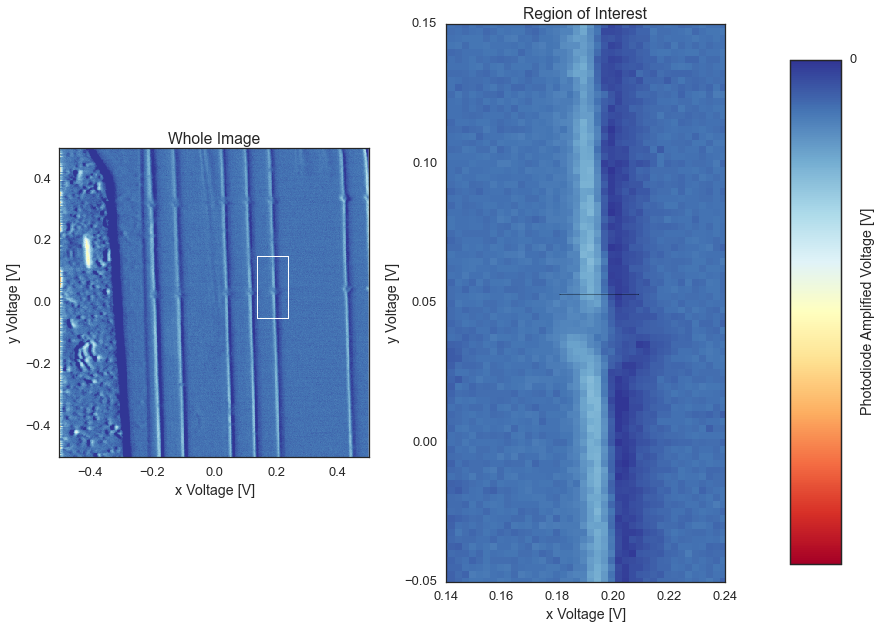

In [218]:
# =============================================
# =============================================
# display image 
# =============================================

# ---------------------------------------------
# adjust the color scale
CLIM_MIN, CLIM_MAX = -0.03, 0
# ---------------------------------------------

# ---------------------------------------------
# set region of interest

# roi = {
#         "xo": -0.037, 'yo': 0.165,
#         "dx": 0.1, 'dy': 0.2,
#         'xPts': 30, 'yPts': 60
#     }

roi = {
        "xo": 0.19, 'yo': 0.05,
        "dx": 0.1, 'dy': 0.2,
        'xPts': 30, 'yPts': 60
    }
# ---------------------------------------------

# =============================================
# =============================================


xo_array = np.linspace(-0.070,-0.00,36)



# ---------------------------------------------
# show whole area scanned by galvo

image_data_scaled = np.clip(image_data, CLIM_MIN, CLIM_MAX)

xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.rio_to_galvoparameter(WHOLE_IMAGE)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False);
whole_image = axes[0].imshow(image_data_scaled, extent = [xVmin, xVmax, yVmin, yVmax], 
               interpolation = 'none', cmap = 'RdYlBu', aspect='auto');

axes[0].set_title('Whole Image')
axes[0].set(aspect=1)
axes[0].set_xlabel('x Voltage [V]')
axes[0].set_ylabel('y Voltage [V]')
axes[1].set_title('Region of Interest')


# Add rectangle of region of interest
axes[0].add_patch( patches.Rectangle( (roi['xo'] - roi['dx']/2, roi['yo'] - roi['dy']/2), 
                                     width=roi['dx'], 
                                     height=roi['dy'], 
                                     fill=False, edgecolor='w', linewidth=1));





# Add blown up region of interest image

roi_image = axes[1].imshow(image_data_scaled, extent = [xVmin, xVmax, yVmin, yVmax], 
               interpolation = 'none', cmap = 'RdYlBu', aspect='equal');
xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.rio_to_galvoparameter(roi)


axes[1].set_xlim([xVmin, xVmax])
axes[1].set_ylim([yVmin, yVmax])
axes[1].set_xlabel('x Voltage [V]')
axes[1].set_ylabel('y Voltage [V]')

fig.subplots_adjust(right=0.8)


# Add colorbars
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar0 = fig.colorbar(whole_image, cax=cbar_ax, ticks = [CLIM_MIN, CLIM_MAX])
cbar1 = fig.colorbar(roi_image, cax=cbar_ax,  ticks = [CLIM_MIN, CLIM_MAX])
cbar1.set_label('Photodiode Amplified Voltage [V]')


#  loop over different xo positions, don't correct for drifts

In [219]:
fo = 1.94065e6
df = 1800.

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/MoveFocus/'
tag = 'Si3Ni4'

start_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
filename = '{:s}_{:s}'.format(start_time,tag) 

# ========================================================================================
# define new interval for sweep 
sweep_parameter = {
    'freqStart' : fo - df/2.,
    'freqEnd' : fo + df/2.,
    'sampleNum' : 451,
    'samplesPerPt' : 8, 
    'xScale' : 0,
    'direction' : 0,
    'loopcount': 1,
    'timeout' : 1e8
}


with open('{:s}.sweep'.format('{:s}/{:s}'.format(dirpath, filename)), 'w') as outfile:
    json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


AMPLITUDE = 1


zi_parameter = {
    'amplitude' : AMPLITUDE,
    'offset' : AMPLITUDE + 1,
    'freq' : 1e5,
    'ACCoupling' : 0, 
    'inChannel' : 0,
    'outChannel' : 0,
    'auxChannel': 0,
    'add' : 1,
    'range' : 10**int(np.ceil(np.log10(amplitude)))
}



with open('{:s}.zi'.format('{:s}/{:s}'.format(dirpath, filename)), 'w') as outfile:
    json.dump(zi_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

zi_hf2 = zi.ZIHF2(zi_parameter['amplitude'],
                  zi_parameter['offset'],
                  zi_parameter['freq'],
                  zi_parameter['ACCoupling'],
                  zi_parameter['inChannel'],
                  zi_parameter['outChannel'],
                  zi_parameter['auxChannel'],
                  zi_parameter['add'],
                  zi_parameter['range']
                 )


# ======================================================================
# start script =========================================================
# ======================================================================

for xo in xo_array:
    print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    
    full_filename = '{:s}/{:s}_xo_{:00.3f}V'.format(dirpath, filename, xo)

    
    rio = {
            "xo": xo, 'yo': 0.162,
            "dx": 0.1, 'dy': 0.2,
            'xPts': 30, 'yPts': 60
        }
    
    print 'current xo: {:00.3f}V'.format(xo)

    # ---------------------------------------------
    # scan RIO
    rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts = track.rio_to_galvoparameter(rio)
    scanner = GalvoScan.ScanNV(rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts,timePerPt, canvas = None)
    rio_image_data = scanner.scan()


    # ---------------------------------------------
    # show image

    # fig = plt.figure(figsize=(20,10))


    fig_RoI = plt.figure()
    X, Y = np.meshgrid( np.linspace(rio_xVmin,rio_xVmax,rio_xPts),  np.linspace(rio_yVmin,rio_yVmax,rio_yPts))

    p = plt.pcolor(X, Y, rio_image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)

    plt.xlim([rio_xVmin, rio_xVmax])
    plt.ylim([rio_yVmin, rio_yVmax])

    plt.axes().set_aspect(rio_yPts / rio_xPts)
    plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20, mew = 0.5)
    # plt.plot(rio['xo'], rio['yo'], 'circ' , ms = 20, mew = 2)
    plt.axes().set_xticks([rio_xVmin, rio_xVmax])
    plt.axes().set_yticks([rio_yVmin, rio_yVmax])
    # save RIO image and data
    counter = 0
    
    fig_RoI.savefig('{:s}.png'.format(full_filename))
    np.savetxt('{:s}.csv'.format(full_filename), rio_image_data, fmt='%.18e', delimiter=',')

    with open('{:s}.rio'.format(full_filename), 'w') as outfile:
         json.dump(rio, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


    # ========================================================================================
    # set laser position
    SetGalvoPoint(rio['xo'], rio['yo']) 

    # ========================================================================================
    # look for mechanical resonance and save sweep data

    zi_hf2.sweep(sweep_parameter['freqStart'],
                 sweep_parameter['freqEnd'],
                 sweep_parameter['sampleNum'],
                 sweep_parameter['samplesPerPt'],
                 sweep_parameter['xScale'],
                 sweep_parameter['direction'],
                 sweep_parameter['loopcount'],
                 sweep_parameter['timeout']
                )



    zi_hf2.writeData('{:s}.dat'.format(full_filename).format(full_filename))



IOError: [Errno 2] No such file or directory: 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/MoveFocus//2015-06-08_11-54-17_Si3Ni4.sweep'

In [ ]:

# ======================================================================
# start script =========================================================
# ======================================================================

for xo in xo_array:
    print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    
    full_filename = '{:s}/{:s}_xo_{:00.3f}V'.format(dirpath, filename, xo)

    
    rio = {
            "xo": xo, 'yo': 0.162,
            "dx": 0.1, 'dy': 0.2,
            'xPts': 30, 'yPts': 60
        }
    
    print 'current xo: {:00.3f}V'.format(xo)

    # ---------------------------------------------
    # scan RIO
    rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts = track.rio_to_galvoparameter(rio)
    scanner = GalvoScan.ScanNV(rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts,timePerPt, canvas = None)
    rio_image_data = scanner.scan()


    # ---------------------------------------------
    # show image

    # fig = plt.figure(figsize=(20,10))


    fig_RoI = plt.figure()
    X, Y = np.meshgrid( np.linspace(rio_xVmin,rio_xVmax,rio_xPts),  np.linspace(rio_yVmin,rio_yVmax,rio_yPts))

    p = plt.pcolor(X, Y, rio_image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)

    plt.xlim([rio_xVmin, rio_xVmax])
    plt.ylim([rio_yVmin, rio_yVmax])

    plt.axes().set_aspect(rio_yPts / rio_xPts)
    plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20, mew = 0.5)
    # plt.plot(rio['xo'], rio['yo'], 'circ' , ms = 20, mew = 2)
    plt.axes().set_xticks([rio_xVmin, rio_xVmax])
    plt.axes().set_yticks([rio_yVmin, rio_yVmax])
    # save RIO image and data
    counter = 0
    
    fig_RoI.savefig('{:s}.png'.format(full_filename))
    np.savetxt('{:s}.csv'.format(full_filename), rio_image_data, fmt='%.18e', delimiter=',')

    with open('{:s}.rio'.format(full_filename), 'w') as outfile:
         json.dump(rio, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


    # ========================================================================================
    # set laser position
    SetGalvoPoint(rio['xo'], rio['yo']) 

    # ========================================================================================
    # look for mechanical resonance and save sweep data

    zi_hf2.sweep(sweep_parameter['freqStart'],
                 sweep_parameter['freqEnd'],
                 sweep_parameter['sampleNum'],
                 sweep_parameter['samplesPerPt'],
                 sweep_parameter['xScale'],
                 sweep_parameter['direction'],
                 sweep_parameter['loopcount'],
                 sweep_parameter['timeout']
                )



    zi_hf2.writeData('{:s}.dat'.format(full_filename).format(full_filename))


(-0.0, 0.162)

In [8]:
SetGalvoPoint(-0.054, rio['yo']) 

<hardware_modules.GalvoMirrors.SetGalvoPoint instance at 0x000000001A923E48>

In [7]:
-0.054, rio['yo']

(-0.054, 0.162)